# TP Coding Convolutional Neural Networks in tensorflow and keras

Task proposed by : Alasdair Newson alasdair.newson@telecom-paristech.fr

In this session, we shall be looking at two subjects :

- A way to visualise what networks are learning : the Deep Dream algorithm
- Adversarial examples

For this, we shall use a famous pretrained network : VGG16. At the heart of these applications is the calculation of the gradient of a loss function with respect to the image itself (instead of respect to the weights). The loss function will be defined depending on the application at hand.


In [1]:
import numpy as np
from keras.preprocessing.image import load_img,img_to_array
from keras.applications import vgg16
#from keras.applications import inception_v3
from keras import backend as K
from keras.layers import Input
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
# This removes all operations linked to training the model
K.set_learning_phase(0)
model=vgg16.VGG16(weights='imagenet',include_top=False)





58892288/58889256 [==============================] - 2s 0us/step








The 'summary' function gives a summary of the architecture so that we can reference its different layers

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [4]:
#put the layers in an easy-to-reference dictionary
layer_dict = dict([ (layer.name,layer) for layer in model.layers])
#get the layer corresponding to the 5th block and second convolution
layer_out = layer_dict['block5_conv2'].output
layer_out.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(512)])

In [0]:
def retrieve_weights(model):
    weight_list = []
    for layer in model.layers:
        weights = layer.get_weights()
        try: weight_list.append(weights[0])
        except: pass
    return weight_list

Now, we are going to visualise a single channel of a filter

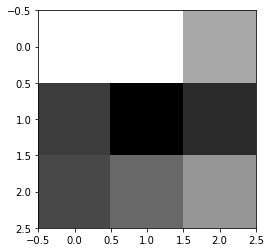

In [7]:
weight_list = retrieve_weights(model)
curr_weight = weight_list[2]
curr_weight.shape
plt.imshow(curr_weight[:,:,0,1],cmap="gray")

In [0]:
curr_weight[:,:,0,1]

array([[ 0.03781697,  0.03759558,  0.01217471],
       [-0.01912256, -0.03680309, -0.02436409],
       [-0.01577048, -0.00621745,  0.00700018]], dtype=float32)

As you can probably see, this visualisation is not of much use : we cannot really tell what is going on in the network. For this, let's turn to another approach : Deep Dream !

## 2. Deep Dream

We now proceed to carry out the Deep Dream algorithm. The idea of the Deep Dream algorithm is to find an image which maximises the response of a network at a certain layer : $\textbf{this should help us understand what the network is learning}$. This can be done with an iterative algorithm, by simply carrying out gradient $\textbf{ascension}$. We start with an input image and iteratively add the gradient of the average response of the features which interest us.

Let's first define a function to preprocess the image. This is needed to put the image in the correct format for the VGG16 network. We also create a function to invert this process.

In [0]:
def format_image(img_file=None):
    # read image
    img = load_img(img_file)
    # convert image to an array
    img_out = img_to_array(img)
    # preprocess the image to put in the correct format for use with the VGG16 network trained on imagenet
    img_out_vgg = vgg16.preprocess_input(img_out)
    img_out_vgg = np.expand_dims(img_out_vgg, axis=0)
    return img_out_vgg, img

def unformat_image(img_in):
    img_out=np.squeeze(img_in)
    #remove offsets added by the VGG16 preprocessing
    img_out[:, :, 0] += 103.939
    img_out[:, :, 1] += 116.779
    img_out[:, :, 2] += 123.68
    # invert the order of the colours : BGR -> RGB
    img_out = img_out[:, :, ::-1]
    #clamp image to the range [0,255] and cast to uint8
    img_out = np.clip(img_out, 0, 255).astype('uint8')
    return img_out

Now, we load the image. At the same time, we create a backend Tensor which has the correct format for the network.

In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


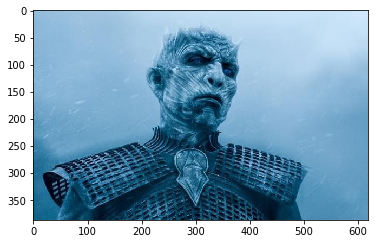

In [11]:
using_colab = False

#load image
img_in,img_visu = format_image('/content/drive/My Drive/got.jpg')
img_backend = model.input
#show the input image
plt.imshow(img_visu)
plt.show()

Now, we define the loss that we wish to maximise. This can be anything you wish, but the a common loss is simply the average response of a certain channel of a certain layer. Since these responses are all positive, due to the non-linearities used, we can safely take the average as a loss function to maximise.


In [0]:
layer_out = layer_dict['block5_conv2'].output
loss = K.mean(layer_out[:, :, :, 15])
grads = K.gradients(loss, img_backend)[0]

Here, we use a little trick. Indeed, it may be the case that the gradients are far too small or far too large for updating, meaning that the updates do nothing or destroy the image. To avoid this, we normalise the gradients.

In [0]:
# normalize the gradient
grads_normalised = grads/ (K.maximum(K.mean(K.abs(grads)), K.epsilon()))

In [0]:
get_loss_and_grads = K.function([img_backend],[loss,grads_normalised])

....................

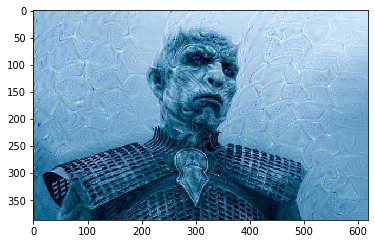

In [18]:
img_in,_ = format_image('/content/drive/My Drive/got.jpg')    
step = 0.1 # Gradient ascent step size
n_iterations = 100  # Number of gradient ascent steps
for ii in range(0,n_iterations):
    loss_value,grads_value = get_loss_and_grads([img_in])
    img_in = img_in + grads_value * step
    if (ii%5==0):
        print(".", end='')
        img_out = unformat_image(np.copy(img_in))
        plt.imshow(img_out)
        plt.imsave('img_out_'+str(ii).zfill(3)+'.png',img_out)

You can try different convolutional layers and see what the results are !

## 3. Adversarial examples

In this part, we will explore the interesting case of adversarial examples. Adversarial examples are images which have been perturbed in a manner which makes the network misclassify the image.

There are many ways to do this, however we can use a similar approach to the one used above, that is to say, we will use a gradient maximisation approach. This consists in iteratively adding the gradient of the loss with respect to the image, to the current image, in order to get a misclassified image.

For this application, we need access to the last, classification, layer of the VGG16 network.

In [19]:
# load model, including last (classification layer)
model=vgg16.VGG16(weights='imagenet',include_top=True)
#create layer dictionary
layer_dict = dict([ (layer.name,layer) for layer in model.layers])
img_backend = model.input
# display architecture
model.summary()

553467904/553467096 [==============================] - 16s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [0]:
def format_image_classif(img_file,img_width=224,img_height=224):
    # read image. Force the image size to a certain shape (uses a resize of the pillow package)
    img = load_img(img_file,target_size=(img_height,img_width))
    # convert image to an array
    img_out = img_to_array(img)
    # preprocess the image to put in the correct format for use with the VGG16 network trained on imagenet
    img_out_vgg = vgg16.preprocess_input(img_out)
    # add a dimension at the beginning, coresponding to the batch dimension
    img_out_vgg = np.expand_dims(img_out_vgg, axis=0)
    return img_out_vgg, img

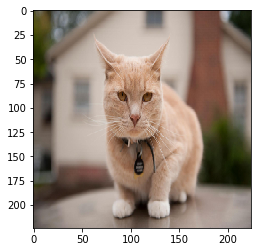

In [21]:
img_in,img_visu = format_image_classif('/content/drive/My Drive/cat_small.png')

plt.imshow(img_visu)

In [22]:
img_in.shape

(1, 224, 224, 3)

In [0]:
layer_dict = dict([ (layer.name,layer) for layer in model.layers])
last_layer = layer_dict["predictions"]
get_prediction_layer = K.function([model.layers[0].input], [last_layer.output, model.layers[-1].output])

We are going to try to force the image to recognise a 'reflex_camera'. This is number 759 of the imagenet classes. You can use any one you like in fact (apart from ones linked to cats, obviously).

In [24]:
target_class = 759
# carry out the network predictions on the example image
y_predicted = model.predict(img_in)
#define the true class as the initial most likely class
true_class = vgg16.decode_predictions(y_predicted)[0][0]
# print the top 5 predicted classes, with the prediction probability
y_predicted_decoded = vgg16.decode_predictions(y_predicted, top=5)[0]
print(y_predicted_decoded)

40960/35363 [==================================] - 0s 0us/step
[('n02124075', 'Egyptian_cat', 0.6696211), ('n02123045', 'tabby', 0.122343), ('n02123159', 'tiger_cat', 0.0912972), ('n02127052', 'lynx', 0.032521587), ('n04141975', 'scale', 0.005070507)]


Now, redefine the loss to be the 'target_class' element of the last layer of the network. This is the element we shall try to maximise, in order to fool the network.

In [0]:
loss = last_layer.output[:, target_class]
grads = K.gradients(loss, img_backend)[0]
# normalize the gradient
grads_normalised = grads/ (K.maximum(K.mean(K.abs(grads)), K.epsilon()))
# create function to retrieve loss and gradients of loss with respect to image
get_loss_and_grads_class = K.function([img_backend],[loss, grads_normalised])

We are now ready to perturb the image such that we misclassify it. Youhoo !

[('n02124075', 'Egyptian_cat', 0.6684069)]
[('n02124075', 'Egyptian_cat', 0.66176033)]
[('n02124075', 'Egyptian_cat', 0.6537978)]
[('n02124075', 'Egyptian_cat', 0.6440608)]
[('n02124075', 'Egyptian_cat', 0.6316789)]
[('n02124075', 'Egyptian_cat', 0.61577046)]
[('n02124075', 'Egyptian_cat', 0.59275854)]
[('n02124075', 'Egyptian_cat', 0.5530817)]
[('n02124075', 'Egyptian_cat', 0.4878643)]
[('n02124075', 'Egyptian_cat', 0.34723094)]
[('n02124075', 'Egyptian_cat', 0.08324251)]
[('n04069434', 'reflex_camera', 0.97471595)]
[('n04069434', 'reflex_camera', 0.9999081)]
[('n04069434', 'reflex_camera', 0.99994564)]
[('n04069434', 'reflex_camera', 0.9999596)]
[('n04069434', 'reflex_camera', 0.9999677)]
[('n04069434', 'reflex_camera', 0.9999728)]
[('n04069434', 'reflex_camera', 0.9999763)]
[('n04069434', 'reflex_camera', 0.999979)]
[('n04069434', 'reflex_camera', 0.99998116)]
End of optimisation
[('n04069434', 'reflex_camera', 0.9999826), ('n03976467', 'Polaroid_camera', 5.100107e-06), ('n03657121'

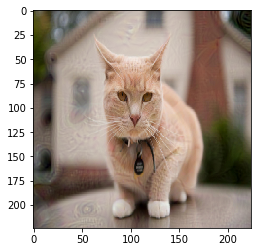

In [26]:
img_in,img_visu = format_image_classif('/content/drive/My Drive/cat_small.png')

#parameters
step = 0.5  # Gradient ascent step size
n_iterations = 100  # Number of gradient ascent steps
for ii in range(0,n_iterations):
    loss_value,grads_value = get_loss_and_grads_class([img_in])
    img_in = img_in + grads_value * step
    if (ii%5==0):
        img_show = unformat_image(np.copy(img_in))
        plt.imsave('img_out_'+str(ii).zfill(3)+'.png',img_show)
        #predict current model to see evolution of top classification
        y_predicted = model.predict(img_in)
        print(vgg16.decode_predictions(y_predicted, top=1)[0])
print('End of optimisation')
img_show = unformat_image(np.copy(img_in))
plt.imshow(img_show)
#show the final top 5 classes
y_predicted = model.predict(img_in)
print(vgg16.decode_predictions(y_predicted, top=5)[0])